In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""
class Network():

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid_vec(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
                
            #if j % 1000 == 0:
            #    if test_data:
            #        print "Epoch {0}: {1} {2}".format(
            #            j, self.evaluate(training_data), self.evaluate(test_data))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid_vec(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime_vec(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            spv = sigmoid_prime_vec(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * spv
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(self.feedforward(x), y) 
                        for (x, y) in test_data]
        return sum( (x - y)**2.0 for (x, y) in test_results)[0][0]
        #return sum(int(x == y) for (x, y) in test_results)
        
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y) 

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

sigmoid_vec = np.vectorize(sigmoid)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

sigmoid_prime_vec = np.vectorize(sigmoid_prime)

Examples of Using Feed-Forward NN with Backpropagation
-------------------------------------------------------

A regression problem.  Combination of 2 sin/cos waves, plus some random noise.  Task, learn to predict the function.

0.0
1.0
[ 0.          0.02564103  0.05128205  0.07692308  0.1025641   0.12820513
  0.15384615  0.17948718  0.20512821  0.23076923  0.25641026  0.28205128
  0.30769231  0.33333333  0.35897436  0.38461538  0.41025641  0.43589744
  0.46153846  0.48717949  0.51282051  0.53846154  0.56410256  0.58974359
  0.61538462  0.64102564  0.66666667  0.69230769  0.71794872  0.74358974
  0.76923077  0.79487179  0.82051282  0.84615385  0.87179487  0.8974359
  0.92307692  0.94871795  0.97435897  1.        ]
[ 0.96244266  1.          0.99333381  0.88616601  0.95705563  0.88111778
  0.9539193   0.7682464   0.71342782  0.66130827  0.74977441  0.82603378
  0.79702957  0.69779974  0.84377567  0.92042118  0.92837056  0.93025656
  0.94143492  0.95949624  0.91627422  0.83222547  0.87554088  0.86829649
  0.63291338  0.4879629   0.27878059  0.28046218  0.20962097  0.
  0.18831392  0.21550427  0.31149075  0.30302644  0.55578931  0.52024676
  0.66204903  0.88678926  0.92329474  0.98611706]


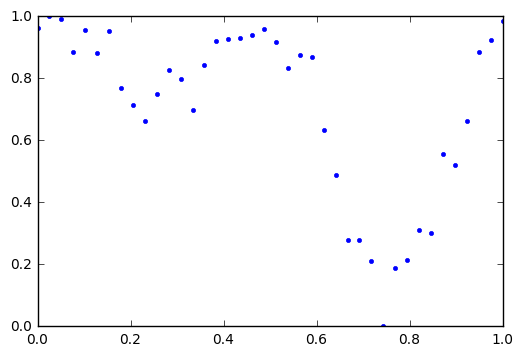

In [3]:
# noisy data in t
x = np.linspace(0, 1, 40)
t = np.sin(2*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(40)*0.25
r = t.max() - t.min()
t = (t - t.min()) / r
plt.plot(x, t, '.')

print t.min()
print t.max()
print x
print t

In [4]:
# use half for training, and split rest between test and validation, e.g. split ratio 50:25:25 train:test:validate
train_input = x[0::2]
test_input = x[1::4]
valid_input = x[3::4]

train_target = t[0::2]
test_target = t[1::4]
valid_target = t[3::4]

train_data = [(input.reshape(1,1), target.reshape(1,1)) for input, target in zip(train_input, train_target)]
test_data  = [(input.reshape(1,1), target.reshape(1,1)) for input, target in zip(test_input, test_target)]
valid_data = [(input.reshape(1,1), target.reshape(1,1)) for input, target in zip(valid_input, valid_target)]


In [5]:
len(valid_data)

10

In [6]:
net = Network( (1, 3, 1) )
net.SGD(train_data, 10000, 1, 0.5, test_data=test_data)

In [7]:
# train a network with 3 nodes in hidden layer, and 1 input and 1 output
mini_batch_size = 1 # full batch learning
num_epochs = 100
learning_rate = 0.5
threshold = 0.0001
net = Network( (1, 3, 1) )

# example, train till validation error starts increasing
epoch = num_epochs
prev2_sse = 102.0
prev1_sse = 101.0

train_sse = net.evaluate(train_data)
valid_sse = net.evaluate(valid_data)

epochs = [0]
train_errors = [train_sse]
valid_errors = [valid_sse]
#while epoch < 5000:
while (prev2_sse - prev1_sse > threshold) or (prev1_sse - valid_sse > threshold):
    net.SGD(train_data, num_epochs, mini_batch_size, learning_rate)
    test_sse = net.evaluate(test_data)
    prev2_sse = prev1_sse
    prev1_sse = valid_sse
    valid_sse = net.evaluate(valid_data)
    train_sse = net.evaluate(train_data)
    if (epoch % 10 == 0):
        print epoch, train_sse, test_sse, valid_sse, prev1_sse - valid_sse
    epoch += num_epochs
    epochs.append(epoch)
    train_errors.append(train_sse)
    valid_errors.append(valid_sse)


100 0.935592433156 0.687549879501 0.624784599609 0.484755516323
200 0.878486382551 0.657967815244 0.630491138193 -0.00570653858366
300 0.862293525812 0.672448653529 0.605812815251 0.0246783229418
400 0.852192658795 0.65999694288 0.61044358316 -0.00463076790961
500 0.853838970032 0.678910214527 0.597003725992 0.0134398571684
600 0.844333928581 0.658401285378 0.607337865786 -0.0103341397937
700 0.842572185661 0.66510432689 0.60125045176 0.00608741402535
800 0.839966755348 0.664330818721 0.600814338897 0.000436112863174
900 0.837167507284 0.662059283666 0.600862888764 -4.85498671211e-05
1000 0.83420954413 0.656188332318 0.604259246008 -0.00339635724421


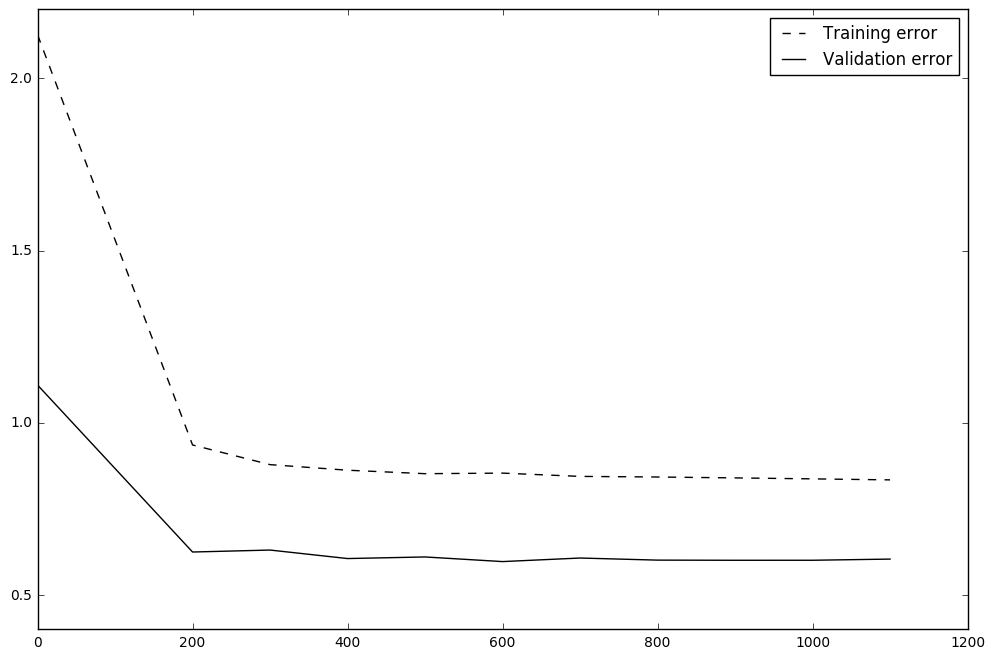

In [8]:
plt.figure(figsize=(12,8))
plt.plot(epochs, train_errors, 'k--', label='Training error')
plt.plot(epochs, valid_errors, 'k-', label='Validation error')
plt.legend()

Lets build a function so will do stopping based on validtion error, and return final train and validation error



In [9]:
def train_till_validation_stops(network_shape, train_data, valid_data,
                                mini_batch_size = 20, learning_rate = 0.25,
                                num_epochs = 100, threshold=0.0001):
    # set up network
    mini_batch_size = 1 # full batch learning
    num_epochs = 100
    learning_rate = 0.5
    net = Network(network_shape)

    # train until network stops learning
    prev2_sse = 102.0
    prev1_sse = 101.0
    train_sse = net.evaluate(train_data)
    valid_sse = net.evaluate(valid_data)

    while (prev2_sse - prev1_sse > threshold) or (prev1_sse - valid_sse > threshold):
        net.SGD(train_data, num_epochs, mini_batch_size, learning_rate)
        prev2_sse = prev1_sse
        prev1_sse = valid_sse
        valid_sse = net.evaluate(valid_data)
        train_sse = net.evaluate(train_data)

    return (train_sse, valid_sse)
    

In [10]:
(train_sse, valid_sse) = train_till_validation_stops( (1, 3, 1), train_data, valid_data)

In [11]:
hidden_conditions = [1, 2, 3, 5, 10, 15, 25, 50]
#hidden_conditions = [75, 100]
num_conditions = len(hidden_conditions)
num_trials = 10
train_errors = np.zeros( (num_conditions, num_trials) )
valid_errors = np.zeros( (num_conditions, num_trials) )

for cond_num, num_hidden in enumerate(hidden_conditions):
    network_shape = (1, num_hidden, 1)
    print "Condition %d num_hidden=%d:" % (cond_num, num_hidden),
    for trial_num in range(num_trials):
        (train_sse, valid_sse) = train_till_validation_stops(network_shape, train_data, valid_data,
                                                             mini_batch_size = 1, learning_rate = 0.5,
                                                             num_epochs = 100, threshold=0.0001)
        train_errors[cond_num, trial_num] = train_sse
        valid_errors[cond_num, trial_num] = valid_sse
        print "%0.4f" % valid_sse,
    print ""
        

Condition 0 num_hidden=1: 0.5592 0.6043 0.5979 0.4683 0.5947 0.4964 0.4645 0.5275 0.5276 0.5814 
Condition 1 num_hidden=2: 0.6120 0.6003 0.0632 0.6101 0.6187 0.5805 0.5843 0.0682 0.0695 0.5526 
Condition 2 num_hidden=3: 0.6115 0.0642 0.6238 0.0565 0.6206 0.5450 0.0663 0.6150 0.6223 0.0659 
Condition 3 num_hidden=5: 0.6263 0.6112 0.6186 0.0635 0.6133 0.0618 0.6455 0.0502 0.5909 0.0621 
Condition 4 num_hidden=10: 0.6229 0.6023 0.0603 0.0510 0.0647 0.0525 0.6672 0.0626 0.6967 0.0685 
Condition 5 num_hidden=15: 0.6786 0.5994 0.0535 0.0539 0.6202 0.6341 0.0677 0.6662 0.6399 0.0632 
Condition 6 num_hidden=25: 0.0672 0.0500 0.6291 0.5973 0.6653 0.0488 0.7554 0.7219 0.6953 0.6808 
Condition 7 num_hidden=50: 0.6848 0.5552 0.6598 0.6609 0.8180 0.0811 0.7263 0.7343 0.0436 0.0471 
